# Python Jupyter Supplement: GP modeling for Variable Annuities

The following notebook is an electronic supplement to the chapter **Gaussian Process Models for Financial Mathematics and Actuarial Science** by M. Ludkovski and J. Risk.

In particular, most of the plots and figures appearing in Section 4 regarding Variable Annuities can be obtained by executing the code below.

## Libraries and Setup

This notebook uses the following Python libraries:
   - ``numpy``: basic linear algebra operations
   - ``sklearn``: for kNN (kernel nearest-neighbors) and linear regression models and error metrics
   - ``pandas``: to use dataframes
   - ``torch``: data structure for EasyGPR
   - ``EasyGPR``: a wrapper for gpytorch developed by J. Risk https://github.com/jimmyrisk/EasyGPR
   - ``matplotlib``: for plotting purposes

It is recommended to follow the installation instructions at https://github.com/jimmyrisk/EasyGPR which outlines getting set up with ``conda``, ``GPyTorch`` (through ``EasyGPR``), and the PyCharm IDE.


In [1]:
# Handle Imports
import numpy as np
import pandas as pd
import torch
from easygpr import GPRModel
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from easygpr.utils.data_handling import MinMaxScaler
from easygpr.utils.data_handling import to_numpy

In [2]:
# Update default plot parameters to enhance readability
# Set up plot parameters to ensure sufficient font size and quality
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb
import matplotlib.pylab as pylab
params = {
    'legend.fontsize': 'medium',
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'font.size': 12,
    'text.usetex': True
}
pylab.rcParams.update(params)

In [1]:
pwd

'C:\\Users\\Mike Ludkovski\\Dropbox\\Mike\\GP Book\\ug_research_chapter\\labs'

In [3]:
# Hide notebook warnings
import warnings
warnings.filterwarnings('ignore')

# Set the random seed
seed = 235790
torch.manual_seed(seed)
np.random.seed(seed)

# Variable Annuity (VA) Data

For more information, please see the book **Metamodeling for Variable Annuities** by *Guojun Gan, Emiliano A. Valdez* which details how this dataset was generated.

First, we import the VA data and perform some data cleaning for our analysis.  

In [4]:
# Load the 'inforce' data frame
path = 'datasets'
inforce = pd.read_csv(f"{path}/inforce.csv")

In [5]:
# Calculate 'age' and 'ttm'
inforce['age'] = (inforce['currentDate'] - inforce['birthDate']) / 365
inforce['ttm'] = (inforce['matDate'] - inforce['currentDate']) / 365

# Select columns for 'dat' from the 'inforce' dataset
vNames = ["gbAmt", "gmwbBalance", "withdrawal"] + [f"FundValue{i}" for i in range(1, 11)]
dat = inforce[vNames + ['age', 'ttm', 'gender', 'productType', 'recordID']]

# Create 'return' variable based on 'productType'
conditions = [
    dat['productType'].str.endswith('RP'),
    dat['productType'].str.endswith('RU'),
    dat['productType'].str.endswith('SU'),
    dat['productType'].isin(['DBAB', 'DBIB', 'DBMB', 'DBWB'])
]
choices = ['RP', 'RU', 'SU', 'SU']
dat['return'] = np.select(conditions, choices, default=np.nan)


# Create new variables as requested
dat['productTypeOld'] = dat['productType']
dat['FVAverage'] = dat[[f"FundValue{i}" for i in range(1, 11)]].mean(axis=1)
# Simplify productType into 6 supercategories
supercategories = {
    'DB': ['DBRP', 'DBRU', 'DBSU'],
    'AB': ['ABRP', 'ABRU', 'ABSU'],
    'IB': ['IBRP', 'IBRU', 'IBSU'],
    'MB': ['MBRP', 'MBRU', 'MBSU'],
    'WB': ['WBRP', 'WBRU', 'WBSU'],
    'MC': ['DBAB', 'DBIB', 'DBMB', 'DBWB']
}
for supercategory, subcategories in supercategories.items():
    dat['productType'].replace(subcategories, supercategory, inplace=True)


# Remove columns 'productTypeOld' and 'FVAverage' from 'dat'
dat.drop(['productTypeOld', 'FVAverage'], axis=1, inplace=True)

# Load the 'greek' dataset
greek = pd.read_csv(f"{path}/Greek.csv")
greek = greek.sort_values(by='recordID').reset_index(drop=True)

# Merge the 'inforce' and 'greek' datasets based on a common identifier, e.g., 'recordID'
merged_data = pd.merge(dat, greek, on='recordID', how='inner')


Here are the columns of the resulting dataset.  We will ignore the ``Delta`` and ``Rho`` variables which are used for a different setting.

In [6]:
print(merged_data.columns)

Index(['gbAmt', 'gmwbBalance', 'withdrawal', 'FundValue1', 'FundValue2',
       'FundValue3', 'FundValue4', 'FundValue5', 'FundValue6', 'FundValue7',
       'FundValue8', 'FundValue9', 'FundValue10', 'age', 'ttm', 'gender',
       'productType', 'recordID', 'return', 'fmv', 'Delta1', 'Delta2',
       'Delta3', 'Delta4', 'Delta5', 'Rho1y', 'Rho2y', 'Rho3y', 'Rho4y',
       'Rho5y', 'Rho7y', 'Rho10y', 'Rho30y'],
      dtype='object')


## Exploratory Data Analysis

Our response variable is Fair Market Value ``fmv``. We  begin by creating boxplots to visualize the effect of various categorical variables on ``fmv''.

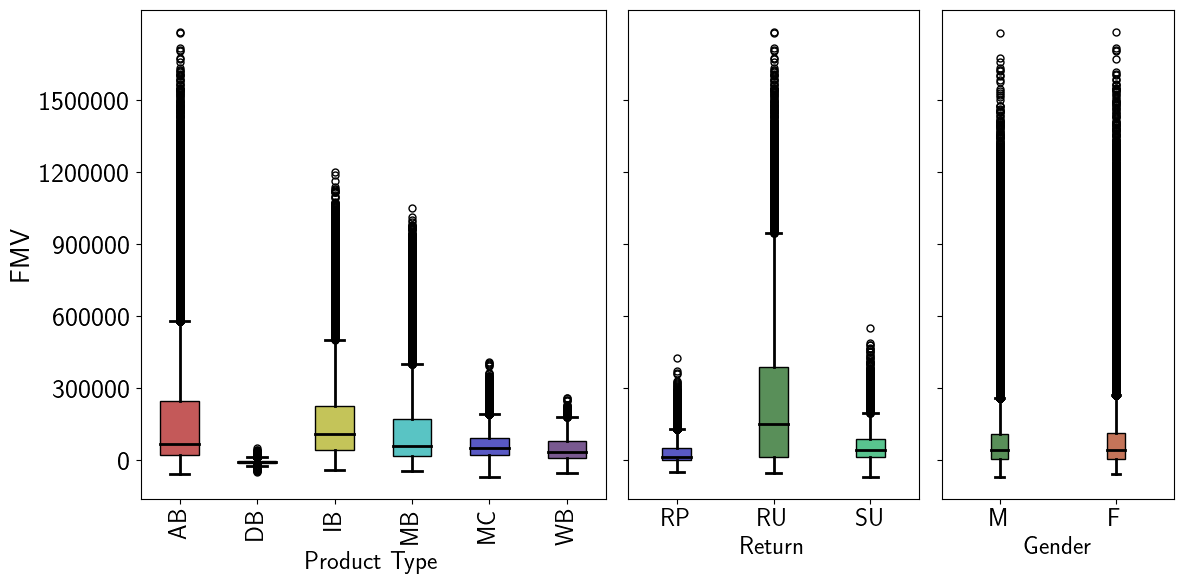

In [7]:
# Create new data set for plotting purposes
merged_data_plt = merged_data.copy()
merged_data_plt['FVAverage'] = merged_data_plt[[f"FundValue{i}" for i in range(1, 11)]].mean(axis=1)
sorted_product_types = sorted(merged_data_plt['productType'].unique())
sorted_return_types = sorted(merged_data_plt['return'].dropna().unique())
box_data_product_type = [merged_data_plt[merged_data_plt['productType'] == pt]['fmv'] for pt in sorted_product_types]
box_data_return = [merged_data_plt[merged_data_plt['return'] == rt]['fmv'] for rt in sorted_return_types]
box_data_gender = [merged_data_plt[merged_data_plt['gender'] == g]['fmv'] for g in ['M', 'F']]

# Generate specific color codes
color_product_type = ['#FF0000', '#FFA500', '#FFFF00', '#00FFFF', '#0000FF', '#4B0082']
color_return = ['#0000FF', '#008000', '#00FF80']
color_gender = ['#008000', '#FF4000']

fig, axes = plt.subplots(1, 3, figsize=(12, 6), gridspec_kw={'width_ratios': [4, 2.5, 2]}, sharey=True)

# Subplots for productType, return, and gender
for i, (box_data, labels, xlabel, colors) in enumerate(zip(
        [box_data_product_type, box_data_return, box_data_gender],
        [sorted_product_types, sorted_return_types, ['M', 'F']],
        ['Product Type', 'Return', 'Gender'],
        [color_product_type, color_return, color_gender])):

    boxplot_elements = axes[i].boxplot(
        box_data, vert=True, patch_artist=True, labels=labels,
        flierprops={'marker': 'o', 'markerfacecolor': 'none', 'markersize': 5, 'markeredgewidth': 1},
        medianprops={'color': 'black', 'linewidth': 2.0},
        whiskerprops={'color': 'black', 'linewidth': 2.0},
        capprops={'color': 'black', 'linewidth': 2.0})

    # Define a factor for darkening and neutralizing the colors
    darkening_factor = 0.6
    neutralizing_factor = 0.7

    for j, patch in enumerate(boxplot_elements['boxes']):
        color_rgb = np.array(to_rgb(colors[j]))  # Convert to RGB tuple

        # Darken the color
        darkened_color = color_rgb * darkening_factor

        # Neutralize the color (blend with gray)
        neutralized_color = (darkened_color + np.array([0.5, 0.5, 0.5])) * neutralizing_factor

        patch.set_facecolor(neutralized_color)

    axes[i].set_xlabel(xlabel, fontsize=18)
    axes[i].tick_params(axis='x', labelrotation=90 if i == 0 else 0, labelsize=18)

# Remove scientific notation
for ax in axes:
    ax.ticklabel_format(style='plain', axis='y')

axes[0].set_ylabel('FMV', fontsize=20)
axes[0].set_yticks([0, 300000, 600000, 900000, 1200000, 1500000])
axes[0].set_yticklabels(axes[0].get_yticks(), fontsize=14)
axes[0].tick_params(axis='y', labelsize=20)

fig.tight_layout()
plt.show()


Next, we visualize the impact of the numeric predictors. The following code makes scatterplots of FMV against the numeric predictors, colored by plan type, compare to **Figure 11** in the article.

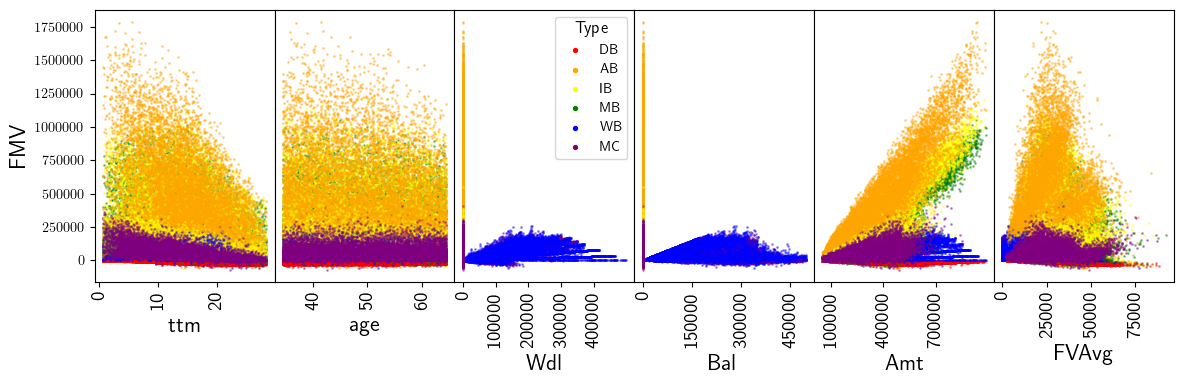

In [10]:
numeric_predictors = ["ttm", "age", "withdrawal", "gmwbBalance", "gbAmt", "FVAverage"]
fmv = merged_data_plt['fmv']  # Assuming 'fmv' is a column in merged_data

fig, axes = plt.subplots(1, len(numeric_predictors), figsize=(12, 4), gridspec_kw = {'wspace':0, 'hspace':0})

# Define custom color palette
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

# Fixed alpha and size values
alpha = 0.4
size = 1

# Number of points to plot in each chunk
chunk_size = 1000

# Manually set x-tick labels
manual_ticks = {
    'ttm': [0, 10, 20, 30],
    'age': [40, 50, 60],
    'withdrawal': [0, 100000, 200000, 300000, 400000],
    'gmwbBalance': [0, 150000, 300000, 450000],
    'gbAmt': [100000, 400000, 700000],
    'FVAverage': [0, 25000, 50000, 75000]
}

# Loop over axes and predictors
x_labels = {'withdrawal': 'Wdl', 'gmwbBalance': 'Bal', 'gbAmt': 'Amt', 'FVAverage': 'FVAvg'}
for idx, (ax, predictor) in enumerate(zip(axes, numeric_predictors)):
    
    ax.set_xticks(manual_ticks[predictor])
    
    # Remove scientific notation from axes
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xticklabels(ax.get_xticks(), rotation=90, fontsize=14)
    ax.set_xlabel(x_labels.get(predictor, predictor), fontsize=16)
    
    if idx == 0:
        ax.set_ylabel('FMV', fontsize=16)
    else:
        ax.set_yticklabels([])  
        ax.yaxis.set_visible(False)  
    
    # Determine jitter factor based on the range of the predictor
    predictor_range = merged_data_plt[predictor].max() - merged_data_plt[predictor].min()
    jitter_factor = predictor_range * 0.001  # Jitter within 0.5% of the range
    
    # Loop over chunks
    max_len = max(len(merged_data_plt[merged_data_plt['productType'] == supercategory]) for supercategory in ['DB', 'AB', 'IB', 'MB', 'WB', 'MC'])
    #max_len = 2000
    for start_idx in range(0, max_len, chunk_size):


        # Loop over supercategories
        for color_idx, supercategory in enumerate(['DB', 'AB', 'IB', 'MB', 'WB', 'MC']):
            mask = (merged_data_plt['productType'] == supercategory)
            sub_data = merged_data_plt[mask].iloc[start_idx:start_idx+chunk_size]
            
            # Apply jitter to x-axis values that are exactly zero
            x_values = sub_data[predictor] + np.random.uniform(-jitter_factor, jitter_factor, size=len(sub_data)) * (sub_data[predictor] == 0)
            
            ax.scatter(x_values, sub_data['fmv'], label=supercategory if start_idx == 0 else "", 
                       s=size, marker='o', color=colors[color_idx], alpha=alpha)
    

# Add single legend to the third plot
legend = axes[2].legend(title='Type', fontsize=10, labelspacing=0.5, framealpha=0.8)
for handle in legend.legendHandles:
    handle.set_sizes([8])
    handle.set_alpha(1)  
    

plt.subplots_adjust(wspace=0)
plt.tight_layout()

plt.savefig('VA-v2.png', dpi=600, bbox_inches='tight')
plt.show()

Alternatively, we re-plot the same scatterplots, but colorcoded by VA type (RA, RU or SU). 

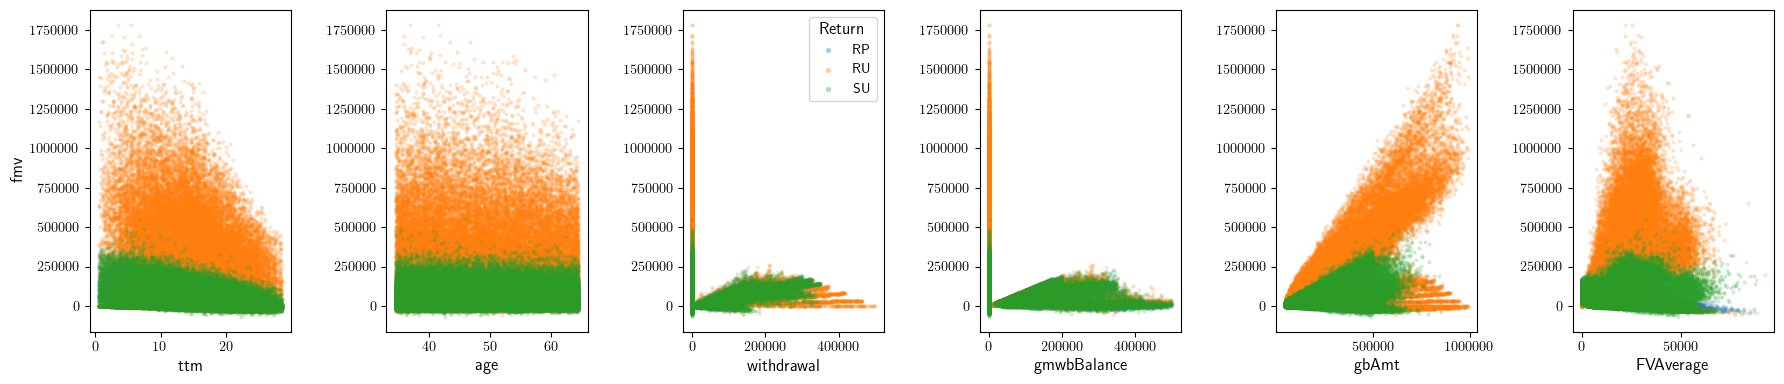

In [9]:
fig, axes = plt.subplots(1, len(numeric_predictors), figsize=(18, 4))

# List of unique 'return' values
unique_returns = sorted(merged_data_plt['return'].dropna().unique())

for idx, (ax, predictor) in enumerate(zip(axes, numeric_predictors)):
    for return_type in unique_returns:
        mask = merged_data_plt['return'] == return_type
        ax.scatter(merged_data_plt[predictor][mask], fmv[mask], label=return_type, s=4, marker='o', alpha=0.15)  # Adjusted size and alpha
    
    # Remove scientific notation from axes
    ax.ticklabel_format(style='plain', useOffset=False)
    
    ax.set_xlabel(predictor)
    ax.set_ylabel('fmv' if idx == 0 else '')  # Show the y-axis label only on the far-left plot
    
    # Only show the legend on the third plot
    if idx == 2:
        legend = ax.legend(title='Return', fontsize=10, labelspacing=0.5, framealpha=0.8)
        for handle in legend.legendHandles:  # Make legend markers match plot markers
            handle.set_sizes([8])
            handle.set_alpha(0.3)

plt.tight_layout()
plt.show()


## Model Fitting

We proceed to fit several statistical models to the VA dataset, including kNN, a linear regressions and GP models with different kernels and prior mean specifications. This workflow consists of several steps below:

1. The "sampling strategy" or "scenario reduction" subsamples the original data according to Latin Hypercube sampling (LHS, see article) to come up with a representative sample, as model fitting  on all the 190,000 VA contracts is computationally impossible.

In [10]:
# Read sampling strategy
S = pd.read_csv(f"{path}/lhs.csv", sep=",", header=None)
S = S.iloc[:, 1].values

2. Categorical predictors are converted into "Dummy" variables via one-hot encoding. Moreover, numeric predictors are each scaled into [0,1] range.  Then training dataset is subsampled according to the LHS mask from step 1.  *(Note: for this dataset, gender has two categories, so we keep only one of them.)*

In [11]:
# Create predictors' matrix X
X_numeric = dat[vNames + ['age', 'ttm']]

# For categorical variables with only two levels, use drop_first since there is only one pair.
X_gender = pd.get_dummies(dat['gender'], drop_first=True, prefix='gender')

# For non-binary variables, do not drop the first category
X_multilevel = pd.get_dummies(dat[['productType', 'return']])

# Concatenate all parts into the final DataFrame
X = pd.concat([X_numeric, X_gender, X_multilevel], axis=1)

# Initialize and fit scalers
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit(X)

# Select samples and target values
Z = X_scaled[S, :]
# Define target values
y = greek.loc[S, 'fmv']     # output is FMV=fair market value
y_scaler = MinMaxScaler()   # scale output into [0,1]
y_scaled = y_scaler.fit(y.values.reshape(-1, 1)).reshape(-1)


3. Initialize containers for holding results, and declare the 8 models.  Here, ``torch.tensor(...)`` is used for anything GP related.

We construct 6 GP models, utilizing either the RBF (squared-exponential), Matern-5/2 or Exponential (Matern-1/2) kernels and either the constant $m_0(x) = \beta_0$ or linear prior mean functions.

In [12]:
hyper_dfs = []
results = []

residuals_dict = {}

# Initialize models
models = {
'Linear Regression': LinearRegression(),
'KNN': KNeighborsRegressor(),
'm1': GPRModel(train_x=torch.tensor(Z), train_y=torch.tensor(y_scaled), kernel="RBF", mean="constant"),
'm2': GPRModel(train_x=torch.tensor(Z), train_y=torch.tensor(y_scaled), kernel="Mat52", mean="constant"),
'm3': GPRModel(train_x=torch.tensor(Z), train_y=torch.tensor(y_scaled), kernel="Exp", mean="constant"),        
'm4': GPRModel(train_x=torch.tensor(Z), train_y=torch.tensor(y_scaled), kernel="RBF", mean="linear"),              
'm5': GPRModel(train_x=torch.tensor(Z), train_y=torch.tensor(y_scaled), kernel="Mat52", mean="linear"),
'm6': GPRModel(train_x=torch.tensor(Z), train_y=torch.tensor(y_scaled), kernel="Exp", mean="linear"),
}


4. Fit models and make predictions. 

To assess model performance we compute the $R^2$, the RMSE (root mean squared error) and the BIC (Bayesian Information Criterion). Note that there is no notion of BIC for kNN.

In [13]:
for model_name, model in models.items():
    if model_name in ['m1', 'm2', 'm3', 'm4', 'm5', 'm6']:
        # Fit GP models
        model.fit_model(training_iterations=1000, verbose = False)
        hyper_dfs.append(model.print_hyperparameters())
    
        # Make predictions for the entire dataset and unscale predictions
        yhat_scaled = model.make_predictions(torch.tensor(X_scaled, dtype=torch.float32), type="f").mean
        yhat = to_numpy(y_scaler.unscale(yhat_scaled.reshape(-1, 1)).reshape(-1))  # Unscaled predictions
    else:
        # Fit kNN or LinearRegr
        model.fit(to_numpy(Z), y)
        yhat = model.predict(to_numpy(X_scaled))
    
    # Calculate performance metrics
    r2 = r2_score(greek['fmv'].values, yhat)
    rmse = np.sqrt(mean_squared_error(greek['fmv'].values, yhat))
    
    # Calculate BIC
    if model_name in ['m1', 'm2', 'm3', 'm4', 'm5', 'm6']:
        bic = model.bic.item()
    elif model_name == 'Linear Regression':
        n = len(y)
        p = X.shape[1]
        mse = mean_squared_error(y, model.predict(to_numpy(Z)))
        bic = n * np.log(mse) + p * np.log(n)
    else:  # KNN
        bic = "NA"
    
    
    # Store the results
    results.append({
        #'Strategy': strategy.replace('.csv', ''),
        'Model': model_name,
        'R²': r2,
        'RMSE': rmse,
        'BIC': bic
    })
    
    print(f"Model: {model_name}, R²: {r2}, RMSE: {rmse}")
    
    # Calculate residuals
    residuals = (greek['fmv'].values) - yhat
    residuals_dict[model_name] = residuals

    # Plot residuals for each model
    plt.figure(figsize=(8, 4))
    plt.scatter(greek['fmv'], residuals, label=f'{model_name} Residuals')
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('FMV (MC)')
    plt.ylabel('Residuals')
    plt.legend()
    plt.title(f'{model_name} Residuals')
    plt.tight_layout()
    plt.savefig(f'{model_name}_residuals.png', dpi=300)
    plt.close()

# Convert results to a pandas DataFrame
results_df = pd.DataFrame(results)


Model: Linear Regression, R²: 0.6359435097181096, RMSE: 102556.7985346756
Model: KNN, R²: 0.6971047316266563, RMSE: 93546.23454830961
Model: m1, R²: 0.9761601931743975, RMSE: 26244.08479276504
Model: m2, R²: 0.977890344529081, RMSE: 25273.829643657304
Model: m3, R²: 0.948432080071508, RMSE: 38598.45072389183
Model: m4, R²: 0.9749374919746, RMSE: 26908.676079756842
Model: m5, R²: 0.9767485148812649, RMSE: 25918.234502759256
Model: m6, R²: 0.9622288770648315, RMSE: 33033.91253569179


## Model Comparison

First, we create a data frame to compare numeric performance measures.  Recall that $R^2$ and RMSE are based on the test set, while BIC is goodness-of-fit on the training set. A portion of the table below is **Table 5** in the article. 

In [14]:
results_df = pd.DataFrame(results)
print(results_df)

               Model        R²           RMSE         BIC
0  Linear Regression  0.635944  102556.798535  7868.24988
1                KNN  0.697105   93546.234548          NA
2                 m1  0.976160   26244.084793  -665.93754
3                 m2  0.977890   25273.829644 -665.886492
4                 m3  0.948432   38598.450724 -503.673424
5                 m4  0.974937   26908.676080 -621.607431
6                 m5  0.976749   25918.234503 -614.271107
7                 m6  0.962229   33033.912536 -521.575576


The next code chunk plots the residuals of each model as a function of response variable ``fmv``, see **Figure 12**  in the article.

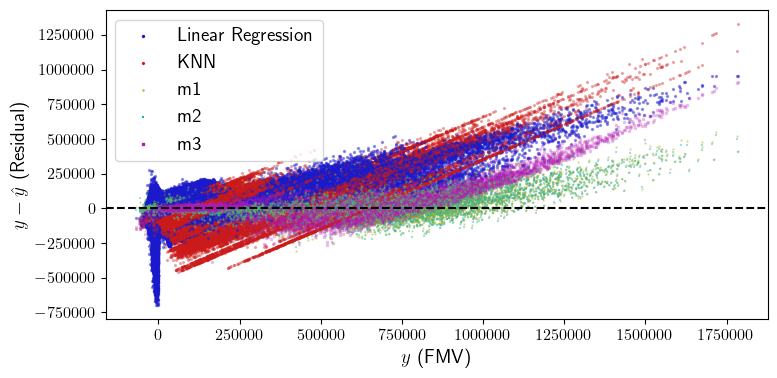

In [15]:
models_to_compare = ['Linear Regression', 'KNN', 'm1', 'm2', 'm3']

# Parameters to tweak point size and transparency
point_size = 2
alpha_value = 0.4
# Set global font size
plt.rcParams['font.size'] = 14

# Create a dictionary to store distinct markers and colors for each model
model_styles = {
    'Linear Regression': {'marker': 'o', 'color': (0.1, 0.1, 0.8), 'alpha': alpha_value},
    'KNN': {'marker': 'x', 'color': (0.8, 0.1, 0.1), 'alpha': alpha_value},
    'm1': {'marker': '.', 'color': (0.7, 0.7, 0.1), 'alpha': alpha_value},
    'm2': {'marker': '+', 'color': (0.1, 0.7, 0.7), 'alpha': alpha_value},
    'm3': {'marker': 's', 'color': (0.7, 0.1, 0.7), 'alpha': alpha_value/2},
    'm4': {'marker': 'd', 'color': (0.15, 0.15, 0.15), 'alpha': alpha_value},
    'm5': {'marker': '^', 'color': (0.7, 0.7, 0.7), 'alpha': alpha_value},
    'm6': {'marker': 'v', 'color': (0.3, 0.7, 0.3), 'alpha': alpha_value},
}

# A dictionary to map the old model names to new names for labeling
model_name_mapping = {
    'm4': 'm1-Lin',
    'm5': 'm2-Lin',
    'm6': 'm3-Lin'
}

# Function to fix alpha transparency value for legend
def fix_legend_alpha(legend):
    for handles in legend.legendHandles:
        handles.set_alpha(1)

# Number of points to plot in each chunk
chunk_size = 1000

# Plot the first combination separately
plt.figure(figsize=(8, 4))
plt.gca().set_facecolor('white')
plt.gca().grid(False)
plt.gca().spines[['top', 'right', 'bottom', 'left']].set_edgecolor('black')

# Remove scientific notation from axes
plt.ticklabel_format(style='plain', axis='both', useOffset=False)

# Determine the maximum length for chunking
max_len = max(len(residuals_dict[model_name]) for model_name in models_to_compare)

# Loop over chunks
for start_idx in range(0, max_len, chunk_size):
    for model_name in models_to_compare:
        sub_data = residuals_dict[model_name][start_idx:start_idx+chunk_size]
        
        plt.scatter(greek['fmv'].iloc[start_idx:start_idx+chunk_size], sub_data, 
                    label=f'{model_name_mapping.get(model_name, model_name)}' if start_idx == 0 else "",
                    alpha=model_styles[model_name]['alpha'], 
                    s=point_size,
                    marker=model_styles[model_name]['marker'], 
                    color=model_styles[model_name]['color'])

plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('$y$ (FMV)')
plt.ylabel('$y - \hat{y}$ (Residual)')
plt.legend()
fix_legend_alpha(plt.legend())


plt.tight_layout()
plt.show()
plt.close()



Next we compare prior mean (constant versus linear) assumptions.

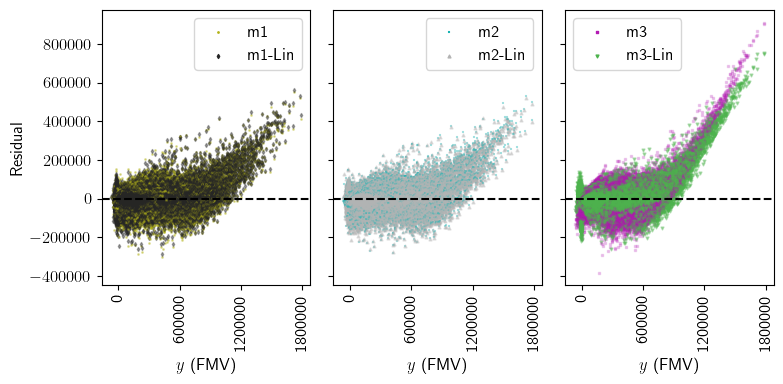

In [16]:
model_combinations = [
    ['m1', 'm4'],
    ['m2', 'm5'],
    ['m3', 'm6'],
]

# Increase the global font size
plt.rcParams['font.size'] = 12

# Number of points to plot in each chunk
chunk_size = 1000

# Plot the remaining combinations as side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1, 1]}, sharey=True)

for ax in axes:
    ax.set_facecolor('white')
    ax.grid(False)
    ax.spines[['top', 'right', 'bottom', 'left']].set_edgecolor('black')
    ax.tick_params(labelsize=12)

# Set the y-axis label only for the first subplot
axes[0].set_ylabel('Residual', fontsize=12)

# Determine the maximum length for chunking
max_len = max(len(residuals_dict[model_name]) for combo in model_combinations for model_name in combo)

# Loop over each subplot index and model combination
for i, combo in enumerate(model_combinations):
    
    # Loop over chunks
    for start_idx in range(0, max_len, chunk_size):
        
        # Loop over each model in the combination
        for model_name in combo:
            
            # Subset of data to plot in this chunk
            sub_data = residuals_dict[model_name][start_idx:start_idx+chunk_size]
            
            # Only label the first chunk to avoid duplicate legend entries
            axes[i].scatter(greek['fmv'].iloc[start_idx:start_idx+chunk_size], sub_data, 
                            label=f'{model_name_mapping.get(model_name, model_name)}' if start_idx == 0 else "", 
                            alpha=model_styles[model_name]['alpha'], 
                            s=point_size * 2,
                            marker=model_styles[model_name]['marker'], 
                            color=model_styles[model_name]['color'])

    axes[i].axhline(y=0, color='k', linestyle='--')
    axes[i].set_xlabel('$y$ (FMV)', fontsize=12)
    x_ticks = [0, 600000, 1200000, 1800000] 
    #x_ticks = [0, 400, 800, 1200, 1600, 2000]
    axes[i].set_xticks(x_ticks)
    axes[i].set_xticklabels([x for x in x_ticks], rotation=90)
    axes[i].legend()
    fix_legend_alpha(axes[i].legend())            


fig.tight_layout()
plt.show()


## Analysis of GP Hyperparameters

To understand the **automatic relevance determination** (ARD) provided by the GP with the RBF kernel, the next code chunk builds a table of the fitted GP hyperparameter values.  

In [17]:
# Initialize lists to store data for each dataframe
hyper_data = []

# Loop through each model (assuming `models` is a list of your model instances)
for model_name in ['m1', 'm2', 'm3', 'm4', 'm5', 'm6']:
    model = models[model_name]
    # Get the hyperparameters DataFrame for the current model
    hyper_df = model.print_hyperparameters(feature_names=X.columns)

    # Create a series for hyper values and append it to the hyper_data list
    hyper_series = pd.Series(hyper_df['Scaled Value'].values, index=hyper_df['Hyperparameter Name'] + ' ' + hyper_df['Feature Name'].fillna(''))
    hyper_data.append(hyper_series)

# Create DataFrames from the lists of series
hyper_df = pd.DataFrame(hyper_data, index=['m1', 'm2', 'm3', 'm4', 'm5', 'm6'])

# For easier reading
hyper_df.columns = hyper_df.columns.str.replace('base_kernel.raw_lengthscale ', '')
hyper_df.columns = hyper_df.columns.str.replace('productType_', '')
hyper_df.columns = hyper_df.columns.str.replace('return_', '')

# Transpose for better viewing
hyper_df_transposed = hyper_df.transpose()



On the $[0,1]$ scale.  Useful for eyeballing "predictor significance." The column for `m2` appears as **Table 7** in the article. 

In [18]:
print(hyper_df_transposed)

                         m1         m2         m3         m4         m5  \
raw_outputscale    0.206737   0.395140   0.020002   0.043787   0.159886   
gbAmt              1.248555   2.454091   2.034529   0.871902   2.089989   
gmwbBalance        1.989189   4.074994   3.596945   1.247442   3.356222   
withdrawal         0.927540   1.666304   6.173311   0.641370   1.474986   
FundValue1         2.711718   5.355145   9.314355   1.915578   4.823621   
FundValue2         1.481325   2.828418  15.063325   1.140917   2.730929   
FundValue3         5.733485  10.582789  26.023451   4.947326   9.510943   
FundValue4         1.376846   2.523359  24.137278   0.936896   2.083028   
FundValue5         5.173924  10.128701   9.488530   4.734487  10.271620   
FundValue6         2.524393   4.646705   4.702116   1.546919   3.826149   
FundValue7         6.047010  11.633873  22.632033   3.948042   7.900741   
FundValue8         8.756902  16.183228  18.356936  10.197900  19.475689   
FundValue9         6.0924